In [1]:
import librosa
import numpy as np
import math
from matplotlib import pyplot as plt
import sounddevice as sd

In [2]:
sample, sr = librosa.load('fsa.wav') #loading the sample

# Defining functions for determining pitch periods
## Picking pitch period
Pitch periods in a signal can be estimated by searching for peaks in autocorrelations calculated on windows of the signal. The autocorrelation of a set of points maps how similar they are to an incrementally delayed copy of themselves. In the context of a periodic signal, the index of a peak in its autocorrelation corresponds to a pitch period.

The function `estimate_pitch_period`, given a window of a signal and a minimum number of frames (corresponding to the highest frequency to consider when determining the pitch), returns the index of a peak in correlation. The indices of the values when sorted high-correlation to low-correlation are iterated through, and the first index greater than the specified value of minimum frames is returned. In a non-periodic signal, the correlation will reduce continuously, so if a value is equal to its index in the sorted indices it can be assumed that the signal is non-periodic. A return value of -1 corresponds to a non-periodic window.

In [7]:
def estimate_pitch_period(window, min_frm):
    autocorrelation = librosa.autocorrelate(window)
    sorted_a = np.argsort(autocorrelation)[::-1] #indices of highest peaks
    ctr = 0
    while ctr < len(autocorrelation):
        if sorted_a[ctr] >= min_frm and ctr != sorted_a[ctr]: #return first peak greater than minimum
            return sorted_a[ctr]
        ctr += 1
    return -1

## Selecting pitch periods across an entire signal
The function `get_pitch_periods` returns the pitch periods present across a whole signal using the above function. The `max_frm` parameter limits the size of the the window in which to determine the autocorrelation, corresponding to the lowest frequency that can be detected. 

Once a pitch period is determined starting at a given point, the starting position for the next window is set to the end of the current pitch period.

In [8]:
def get_pitch_periods(signal, min_frm, max_frm):
    pitches = np.zeros(len(signal) - max_frm + 1)
    ctr = 0
    while ctr < (len(signal) - max_frm + 1):
        window = signal[ctr:ctr + max_frm]
        pitch_period = estimate_pitch_period(window, min_frm)
        if pitch_period != -1:
            pitches[ctr:ctr + pitch_period] = pitch_period
        ctr += 1 #increment starting point for next window by estimated pitch period
    return np.array(pitches, dtype=int)

In [9]:
min_freq = 90
max_freq = 525 #min and max frequencies, in Hz
min_frm = int(sr / max_freq)
max_frm = int(sr / min_freq) #(number of frames corresponding to a frequency) = sampling rate / frequency

Text(0, 0.5, 'Pitch period (samples)')

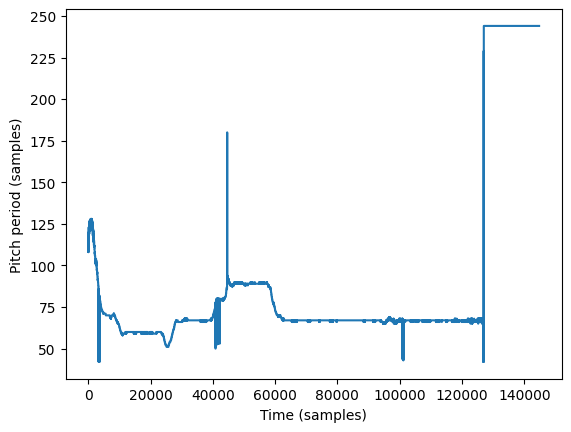

In [11]:
pitches = get_pitch_periods(sample, min_frm, max_frm)
plt.plot(pitches)
plt.xlabel("Time (samples)")
plt.ylabel("Pitch period (samples)")

# Processing pitch data
## Smoothing the detected pitches
As can be seen, while the estimated pitch periods do mostly follow the pitch of the signal, there are a number of undesirable spikes in the data. The function `smoothe` evens out any sudden spikes in the data above a threshold by tracking the difference between a point and its predecessor.

In [12]:
def spike_smoothe(pitches, threshold):
    p_diff = [pitches[i - 1] - pitches[i] for i in range(1, len(pitches))]
    new_p = np.zeros_like(pitches)
    new_p[0] = pitches[0]
    offset = 0
    for i in range(1, len(pitches)):
        if abs(p_diff[i-1]) > threshold:
            offset += p_diff[i-1]
        new_p[i] = pitches[i] + offset
    for i in range(len(pitches)):
        if abs(new_p[i] - pitches[i]) < threshold:
            new_p[i] = pitches[i]
    return new_p

def interp_smooth(pitches, winsize):
    new_p = np.zeros_like(pitches)
    new_p[0] = pitches[0]
    for i in range(1, len(pitches) - 2*winsize, winsize):
        new_p[i:i+winsize] = np.linspace(new_p[i-1], max(pitches[i+winsize:i+winsize*2]), winsize+1)[1:]
    new_p[i+winsize:] = np.linspace(new_p[i+winsize-1], pitches[-1], len(pitches) - (i+winsize-1))[1:]
    return np.rint(new_p)

Text(0, 0.5, 'Pitch period (samples)')

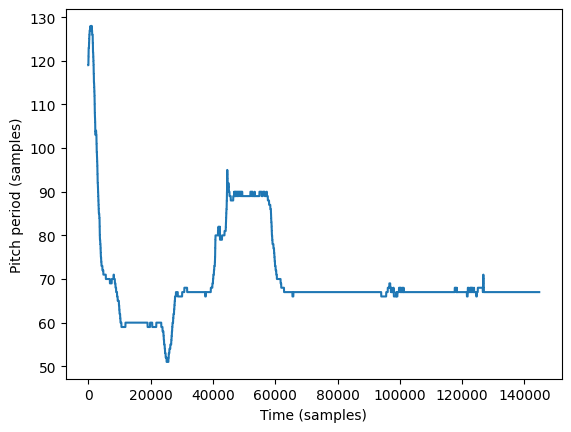

In [13]:
pitches = interp_smooth(spike_smoothe(pitches, 10), 100)
plt.plot(pitches)
plt.xlabel("Time (samples)")
plt.ylabel("Pitch period (samples)")

# Manipulating the sample using pitch data
## Stretching the sample by a whole number factor
After calculating the pitch contour, stretching a sample by a factor of a whole number is relatively trival. A new array of zeroes is created, with its length equal to the original signal length multiplied by the stretching factor, and counters for the indices in the pitch contour (`pitch_pos`) and new sample (`new_sig_pos`) arrays are initialised to zero. An array for the pitch contour of the stretched signal is also created, for reasons that will become apparent later.

A window twice the size of the corresponding pitch period is selected from the signal, starting from the index specified by `pitch_pos`, and a Hanning window is applied to it. This is added to the new signal array element-wise starting from `new_sig_pos`, and `new_sig_pos` is incremented by half the window length. The previous step is repeated as many times as specified by `stretch_factor`, after which `pitch_pos` is incremented by the current pitch period. This process is then repeated until the end of the pitch contours is reached.

In [11]:
def stretch_sample_whole_number(signal, pitches, stretch_factor):
    new_sig = np.zeros(signal.shape[0]*stretch_factor) #array for stretched signal
    new_pitches = np.repeat(pitches, stretch_factor) #corresponding pitches
    pitch_pos = 0
    new_sig_pos = 0 #position indices
    while pitch_pos < len(pitches):
        if pitches[pitch_pos] != -1:
            win_len = int(min(2 * pitches[pitch_pos], len(pitches) - pitch_pos)) # window length is double the pitch sample length
            pitch_period = signal[pitch_pos:pitch_pos + win_len] * np.hanning(win_len) # taper the sides to allow overlap
            for _ in range(stretch_factor):
                new_sig[new_sig_pos:new_sig_pos + win_len] += pitch_period # add overlapping sample
                new_sig_pos += win_len // 2 #increment position in signal by half of the window length
            pitch_pos += int(pitches[pitch_pos]) #skip intermediate pitch positions
        else:
            break
    return new_sig, new_pitches

In [12]:
sample_stretch_2, _ = stretch_sample_whole_number(sample, pitches, 2)
sd.play(sample_stretch_2, sr)

## Stretching a sample by a floating point number
Using the above function (`stretch_sample_whole_number`), the length of the sample is multiplied by the whole number part of the stretch factor. To reach the desired stretch factor, the sums of pitch periods at evenly spaced intervals of the stretched signal are calculated until an interval is found that increases the sample length to (roughly) the desired size. This method may not give the exact desired stretch factor, but it is close enough for this purpose. Note that this function cannot squeeze a sample (stretch factor < 1).

In [14]:
def stretch_sample(signal, pitches, stretch_factor):
    whole_num_component = int(stretch_factor)
    new_sig = np.zeros(math.ceil(signal.shape[0]*stretch_factor)) # empty array for output
    sig_cpy = np.copy(signal)
    pitches_cpy = np.copy(pitches) # copy signal and pitches
    if stretch_factor >= 2:
        sig_cpy, pitches_cpy = stretch_sample_whole_number(sig_cpy, pitches_cpy, whole_num_component) # pre stretch by whole number cmpt
        if stretch_factor == whole_num_component:
            return sig_cpy
    n_excess_samples = abs(round(len(pitches_cpy) * stretch_factor / whole_num_component) - len(pitches_cpy)) # calculate extra number of samples to add
    rough_excess_samples = 0
    divs = 0 # number of points at which to double a pitch period
    while rough_excess_samples < n_excess_samples:
        divs += 1
        rough_excess_samples = np.sum(pitches_cpy[np.linspace(0, len(pitches_cpy) - 1, divs, dtype=int)])
    edit_idcs = np.linspace(0, len(pitches_cpy) - 1, divs, dtype=int)
    pitch_pos = 0
    new_sig_pos = 0
    extra_window_idx = 0
    while pitch_pos < len(pitches_cpy):
        if pitches_cpy[pitch_pos] != -1: # if pitch is present
            win_len = int(pitches_cpy[pitch_pos] * 2)
            pitch_period = sig_cpy[pitch_pos:pitch_pos + win_len] * np.hanning(win_len)
            if extra_window_idx < len(edit_idcs) and pitch_pos > edit_idcs[extra_window_idx]:
                extra_window_idx += 1
                if stretch_factor > 1:
                    for _ in range(2):
                        new_sig[new_sig_pos:new_sig_pos + win_len] += pitch_period
                        new_sig_pos += win_len // 2
            else:
                new_sig[new_sig_pos:new_sig_pos + win_len] += pitch_period 
                new_sig_pos += win_len // 2
            pitch_pos += int(pitches_cpy[pitch_pos])
        else:
            pitch_pos += 1
    return new_sig

## Formant shift and pitch shift
Now that we can stretch the sample in time without changing the pitch, we can use linear interpolation for some interesting effects. We can change the tone of the voice without affecting the fundamental frequency by resampling the pitch windows to different sizes. We can also shift the pitch (up only).

In [15]:
def linear_resample(original, target_len):
    index_arr = np.linspace(0, len(original) - 1, target_len)
    index_floor = np.array(index_arr, dtype=int)
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor
    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    return  val1 * (1.0 - index_rem) + val2 * index_rem

def formant_shift(signal, pitches, formant_pitch_factor):
    new_sig = np.zeros(signal.shape[0])
    pitch_pos = 0
    while pitch_pos < len(pitches):
        if pitches[pitch_pos] != -1:
            win_len = int(pitches[pitch_pos] * 2)
            new_win_len = min(round(win_len * formant_pitch_factor), len(new_sig)-pitch_pos)
            pitch_period = signal[pitch_pos:pitch_pos + win_len] * np.hanning(win_len)
            new_sig[pitch_pos:pitch_pos + new_win_len] += linear_resample(pitch_period, new_win_len)
            pitch_pos += win_len // 2
        else:
            pitch_pos += 1
    return new_sig

def pitch_shift(signal, pitches, pitch_factor):
    sig_fs = formant_shift(signal, pitches, pitch_factor)
    stretch_sig = stretch_sample(sig_fs, pitches, pitch_factor)
    return linear_resample(stretch_sig, len(signal))

In [24]:
ps = pitch_shift(sample, pitches, 1.6)

In [25]:
sd.play(ps, sr)